#### Template for main
#### Research paper: 
#### Copy of data: 


In [1]:
#!pip install import-ipynb
#!pip install import contextlib
#!pip install gensim

In [2]:
import import_ipynb
import contextlib
import random
import gensim.parsing.preprocessing as preprocessing

In [3]:
# Import Jupyter Notebook files
with contextlib.redirect_stdout(None):
    #ToDo import the correct data processor: JSON or CSV
    #from JSON_Processor import *
    from CSV_Processor import *
    from Reading_Level import *
    from Wordcloud import *
    from Word_Processing import *
    from Utilities import *

In [4]:
def get_random_question(questions):
    '''
    Extract a random question 
    @param questions list: a list of dictionaries, each a question. 
    @param source_id str: the desired source of the question. Defaults to None for don't care.  
    @return dictionary: The random question as a dictionary
    '''
    return random.choice(questions)

In [5]:
def print_question(question):
    '''
    Print a question
    @param question dictionary: The question to be printed
    @return: None
    '''
    #print("print_question():", question)
    print("Input:", question["input"])
    print("Target:", question["target"])
    # if there are any other keys, print those as well
    for key in [key for key in question.keys() if key not in ["input", "target"]]:
        print(key + ":", question[key])

In [6]:
def get_data_files(path, extension):
    '''
    Extract data files from a list of file paths
    @param path str: The file path to be processed
    @param extension string: the file extension to be used when filtering the files in the path. Include the "." in this value.
    @return list: The list of files with the extension specified
    '''
    print("path:", path)
    all_files = read_directory_contents(path)
    return [file for file in all_files if file.endswith(extension)]

In [7]:
def load_questions(benchmark_name, question_path):
    '''
    Read questions from a directory containing one or more question files
    @param benchmark_name string: the name of the benchmark, must be a folder in the filesystem where the data folder can be found,
    @param question_path string: The location of the question file(s)
    @return dictionary: key "questions" is a list of dictionaries, one dictionary for each question. Key "data_files" is a list of the file names that were processed
    '''
    results = dict()
   # ToDo edit the extension: .csv", "json", or ".jsonl", etc.
    data_files = get_data_files(benchmark_name + "/"  + question_path, ".csv")
    print("data files:", data_files)

    # ToDo - Use the correct Processor class for this benchmark. Look in Json_processor.ipynb and CSV_Processor.ipynb
    data_processor = FarelBench_CSV_Processor(benchmark_name + "/" + question_path, data_files)   
        
    questions = data_processor.read_data()
    results["questions"] = questions
    results["data_files"] = data_files
    return results

In [8]:
def build_text_from_questions(questions, write_to = None, remove_stopwords = True):
    '''
    Build one long text string from all the questions.
    This logic will vary based on the architecture of the benchmark questions.
    @param questions list: list of dictionaries, one dictionary per question.
    @param write_to string: File path to write the text string. Default is None. 
    @param remove_stopwords bool: True to remove stopwords from the text string. Defaults to True
    @return String: The text string
    '''
    text = ""
    for question in questions:
        text += " " + str(question["input"]) + " " + str(question["target"])
    text_without_stopwords = preprocessing.remove_stopwords(text)
    if write_to != None:
        write_string_to_file(text, write_to)
        write_string_to_file(text_without_stopwords, write_to.replace(".txt", "_stopwords_removed.txt"))

    if remove_stopwords:
        #print(text_without_stopwords[0:1000])
        return text_without_stopwords
    else:
        return text

In [9]:
def compute_readability_indices(benchmark_name, questions, verbose = True):
    '''
    Compute readability values using our Reading_Level class
    @param questions list: A list of dictionaries, one dictionary per benchmark question
    @param verbose bool: True if this function should print the computed values
    @return dictionary: key is the readability metric, value is the corresponding score
    '''
    text = build_text_from_questions(questions, remove_stopwords = False)
    indices = Reading_Level.compute_readability_indices(benchmark_name, text)

    if (verbose):
        print("Readability Indices:")
        for index, score in indices.items():
            print(f"{index}: {score:.2f}")
    return indices

In [10]:
def generate_wordcloud(benchmark_name, questions):
    '''
    Build a word cloud based on the questions in a benchmark
    @param questions list: List of dictionaries, each dictionary os a question from the benchmark
    @return None
    '''
    text = build_text_from_questions(questions)

    wordcloud = Wordcloud()
    wordcloud.generate01(benchmark_name, text, myStopwords={"the", "and"})

In [11]:
def compute_word_frequency(benchmark_name, questions, verbose = True, min_percentage = 1.0):
    '''
    Compute the word frequencies in the benchmark questions
    @param questions list: List of dictionaries, each dictionary os a question from the benchmark
    @param verbose bool: True if the function should print the word frequencies
    @param min_percentage float: the smallest percentage that should be printed. Defaults to 1.0
    @return set (dictionary, float): ({word:# of times that word appears over all questions}, total words)
    '''
    text = build_text_from_questions(questions)

    word_frequency, count = Word_Processing.compute_word_frequency(text)
    sorted_word_frequency = {k: v for k, v in sorted(word_frequency.items(), key=lambda item: item[1], reverse = True)}
    count = float(count)
    write_dict_to_file(sorted_word_frequency, ".\\" + benchmark_name + "\\results\\word_frequency.txt", length = 100, denominator = count)
    if verbose:
        print("Word Frequency:")
        #for key in [key for key in sorted_word_frequency.keys()][:5]:
        for key in sorted_word_frequency.keys():
            percentage = (sorted_word_frequency[key] / count)* 100
            if percentage >= min_percentage:
                print(key, ":", sorted_word_frequency[key], ",", '{0:.2f}'.format(percentage))

    return (sorted_word_frequency, count)

In [12]:
def compute_longest_words(benchmark_name, questions, verbose = True):
    '''
    Compute the longest words appearing across all the questions
    @param questions list: List of dictionaries, each dictionary is a question from the benchmark
    @param verbose bool: True if the function should print the words
    @return set (dictionary, float): ({word:# of times that word appears over all questions}, total words)    
    '''

    text = build_text_from_questions(questions)

    word_length, count = Word_Processing.compute_longest_words(text, min_length = 12)
    #sorted_word_lengths = {k: v for k, v in sorted(word_length.items(), key=lambda item: item[1], reverse = True)}
    sorted_word_lengths = {k: v for k, v in sorted(word_length.items(), key=lambda item: len(item[0]), reverse = True)}
    count = float(count)
    if verbose:
        print("Longest Words:")
        for key in list(sorted_word_lengths.keys())[0:25]:
            print(len(key), ", ", key, ":", sorted_word_lengths[key], ",", '{0:.2f}'.format((sorted_word_lengths[key] / count)* 100))

    # Write all the missing words to a text file
    write_dict_keys_to_file(sorted_word_lengths, ".\\" + benchmark_name + "\\results\\longest_words.txt", 100)

    return (sorted_word_lengths, count)

In [13]:
def find_word(questions, word):
    return Word_Processing.find_word(questions, word)

In [14]:
def find_missing_words(benchmark_name, questions, verbose = True, very_verbose = False):
    """
    Find words not in the English dictionary. Numbers are ignored in this function.
    @param questions dictionary: The data to be processed
    @param verbose bool: If true, print some information about the first 10 words not found in the dictionary. Default to True
    @param very_verbose bool: If true, print the questions containing the first 10 words that were not found in the dictionary. Default to False.
    
    @return dictionary: The unique words. key and value are both the unique word
    """
    text = build_text_from_questions(questions, ".\\" + benchmark_name + "\\results\\questions_as_text.txt")
    print("Text built...")
    english = Word_Processing.load_dictionary()
    print("Dictionary loaded...")

    words = Word_Processing.split_text(text)
    print("Text split...")
    words_not_found = dict()
    print("Processing word list...")
    for word in words:
        try:
            # If this fails, the word is not a number and we will add it to the dictionary of missing words.
            tmp = float(word)
        except:
            if word.upper() not in english:
                words_not_found[word] = word
                #words_not_found.add(word)
    # Write all the missing words to a text file
    write_dict_keys_to_file(words_not_found, ".\\" + benchmark_name + "\\results\\words_not_in_dictionary.txt", length = len(words_not_found))

    if verbose:
        print(len(words_not_found), "words not in dictionary")
        print("First 10 words not in dictionary:")
        for i, key in enumerate(words_not_found.keys()):
            if i >= 10:
              break
            print(key)
    if very_verbose:
        print("First 10 words not in dictionary and the questions those words appear in:")
        for i, key in enumerate(words_not_found.keys()):
            if i >= 10:
                break
            print(key)
            print(key , "found in", find_word(questions, key))
    
    return words_not_found

In [15]:
def demo():
    benchmark_name = "Farel-Bench"     # ToDo - Add the desired benchmark name. This must correspond to the folder name in the project
    question_path = "data/"
    result = load_questions(benchmark_name, question_path)
    questions = result["questions"]
    data_files = result["data_files"]
    print(len(questions), "questions read from", len(data_files), "files in", question_path)
    print("-------------------------------------------------------")

    random_question = get_random_question(questions)
    print("Random question:")
    print_question(random_question)
    print("-------------------------------------------------------")

    words_not_found = find_missing_words(benchmark_name, questions)
    print("-------------------------------------------------------")

    compute_readability_indices(benchmark_name, questions)
    print("-------------------------------------------------------")
    
    generate_wordcloud(benchmark_name, questions)
    print("-------------------------------------------------------")

    compute_word_frequency(benchmark_name, questions)
    print("-------------------------------------------------------")
    
    compute_longest_words(benchmark_name, questions)

path: Farel-Bench/data/
data files: ['farel_bench.csv']
TruthfulQA_CSV_Processor.__init__: self.question_path: Farel-Bench/data/ self.input_files: ['farel_bench.csv']
CSV file path: Farel-Bench/data/farel_bench.csv
1000 questions read from 1 files in data/
-------------------------------------------------------
Random question:
Input: "Given the family relationships: * Barbara is Hannah's parent. * Doris is Frances' parent. * Olivia is Barbara's parent. * Doris is Olivia's parent. * Karen is Doris' parent.
Target: What is Frances' relationship to Olivia? Select the correct answer: 1. Frances is Olivia's sibling. 2. Frances is Olivia's grandparent. 3. Frances is Olivia's grandchild. Enclose the selected answer number in the <ANSWER> tag
topic: sibling
-------------------------------------------------------
Text built...
Dictionary loaded...
Text split...
Processing word list...
1 words not in dictionary
First 10 words not in dictionary:
1X
-----------------------------------------------

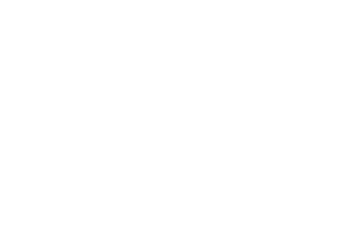

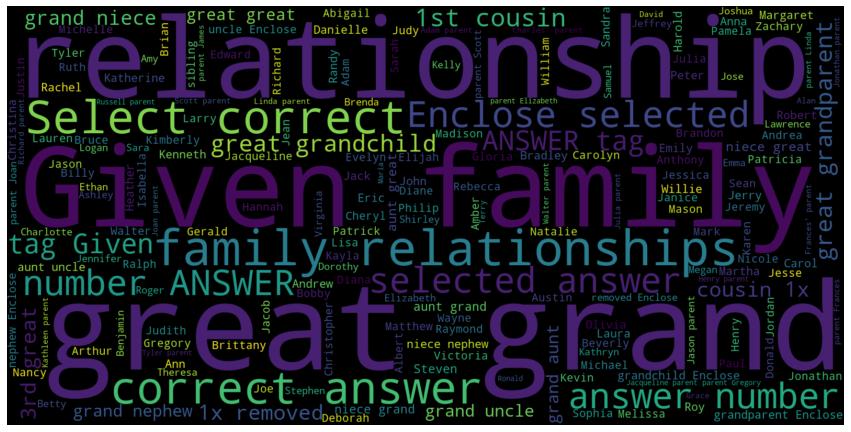

In [16]:
if __name__ == "__main__":
    #raise Exception("This is the template. Remove this line, build the proper directory structure, and edit the 'ToDo's in this notebok before running it.")
    demo()